In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version Î∞è gpu ÌôïÏù∏
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## 1. Tokenizer Ï§ÄÎπÑ
8000Ïùò vocab_sizeÎ•º Í∞ñÎäî sentencepiece Î™®Îç∏

In [6]:
import sentencepiece as spm
import os

corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

data_dir = './data'
model_dir = './models'

model_prefix = model_dir + '/ko_8000'

pretrain_json_path = data_dir + '/bert_pre_train.json'

vocab_size = 8000

In [48]:
print(model_prefix)
print(pretrain_json_path)
mm = f"{model_dir}/ko_8000"
mm

./models/ko_8000
./data/bert_pre_train.json


'./models/ko_8000'

In [2]:

spm.SentencePieceTrainer.train(f"--input={corpus_file} \
                               --model_prefix={model_prefix} \
                               --vocab_size={vocab_size + 7} \
                               --model_type=bpe \
                               --max_sentence_length=999999 \
                               --pad_id=0 --pad_piece=[PAD] \
                               --unk_id=1 --unk_piece=[UNK] \
                               --bos_id=2 --bos_piece=[BOS] \
                               --eos_id=3 --eos_piece=[EOS] \
                               --user_defined_symbols=[SEP],[CLS],[MASK]")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/bert_pretrain/data/kowiki.txt                                --model_prefix=models/ko_8000                                --vocab_size=8007                                --model_type=bpe                                --max_sentence_length=999999                                --pad_id=0 --pad_piece=[PAD]                                --unk_id=1 --unk_piece=[UNK]                                --bos_id=2 --bos_piece=[BOS]                                --eos_id=3 --eos_piece=[EOS]                                --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: models/ko_8000
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 100000

In [9]:


# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_prefix}.model")

vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

# ÌôïÏù∏
print(f"Ï†ïÏÉÅ ÌÜ†ÌÅ∞ Ïàò: {len(vocab_list)}")
print("ÏòàÏãú:", vocab_list[1:10])

Ï†ïÏÉÅ ÌÜ†ÌÅ∞ Ïàò: 8000
ÏòàÏãú: ['‚ñÅÏù¥', 'ÏúºÎ°ú', 'ÏóêÏÑú', '‚ñÅÏûà', '‚ñÅ2', '‚ñÅÍ∑∏', '‚ñÅÎåÄ', '‚ñÅÏÇ¨', 'Ïù¥Îã§']


## 2. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (1) MASK ÏÉùÏÑ±
BERTÏùò MLMÏóê ÌïÑÏöîÌïú ÎπàÏπ∏(mask)ÏùÑ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤¥ ÌÜ†ÌÅ∞Ïùò 15% Ï†ïÎèÑÎ°ú ÎßåÎì§Ïñ¥ Ï£ºÏÑ∏Ïöî. 
Í∑∏ Ï§ë 80%Îäî [MASK] ÌÜ†ÌÅ∞, 10%Îäî ÎûúÎç§Ìïú ÌÜ†ÌÅ∞, ÎÇòÎ®∏ÏßÄ 10%Îäî ÏõêÎûòÏùò ÌÜ†ÌÅ∞ÏùÑ Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïòÏÑ∏Ïöî

In [52]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    :param tokens: tokens
    :param mask_cnt: mask Í∞úÏàò (Ï†ÑÏ≤¥ tokensÏùò 15%)
    :param vocab_list: vocab list (random token Ïö©)
    :return tokens: maskÎêú tokens
    :return mask_idx: maskÎêú tokenÏùò index
    :return mask_label: maskÎêú tokenÏùò ÏõêÎûò Í∞í
    """
    # Îã®Ïñ¥ Îã®ÏúÑÎ°ú mask ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú index Î∂ÑÌï† (ÎùÑÏñ¥Ïì∞Í∏∞)
    cand_idx = []  # word Îã®ÏúÑÏùò index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"Îäî Îã®Ïñ¥Ïùò ÏãúÏûëÏùÑ ÏùòÎØ∏ÌïòÎäî Í∞í
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random maskÎ•º ÏúÑÌï¥ÏÑú ÏàúÏÑúÎ•º ÏÑûÏùå (shuffle)
    random.shuffle(cand_idx)
    
    # mask Ïã§Ìñâ
    mask_lms = []  # mask Îêú Í∞í
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # Ìï∏Ïû¨ maskÎêú Í∞úÏàòÍ∞Ä 15%Î•º ÎÑòÏúºÎ©¥ Ï§ëÏßÄ
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # Ïù¥Î≤àÏóê maskÌï† Í∞úÏàòÎ•º Ìè¨Ìï®Ìï¥ 15%Î•º ÎÑòÏúºÎ©¥ skip
              continue
        dice = random.random()  # 0Í≥º 1 ÏÇ¨Ïù¥Ïùò ÌôïÎ•† Í∞í

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            
            mask_lms.append({"index": index, "label": tokens[index], "masked": masked_token})
            tokens[index] = masked_token

    # mask_lms Ï†ïÎ†¨ ÌõÑ mask_idx, mask_label Ï∂îÏ∂ú (sorted ÏÇ¨Ïö©)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    #return tokens, mask_lms, mask_idx, mask_label
    return tokens, mask_idx, mask_label

## 3. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (2) NSP pair ÏÉùÏÑ±

In [53]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_bÏùò Í∏∏Ïù¥Î•º Ï§ÑÏûÑ ÏµúÎåÄ Í∏∏Ïù¥: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: Îëê tokens Í∏∏Ïù¥Ïùò ÏµúÎåÄ Í∞í
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):  
            del tokens_a[0]                      # AÍ∞Ä Îçî Í∏∏Î©¥ ÏïûÏóêÏÑú ÌïòÎÇò Ï†úÍ±∞
        else:
            tokens_b.pop()                       # BÍ∞Ä Îçî Í∏∏Í±∞ÎÇò Í∞ôÏúºÎ©¥ Îí§ÏóêÏÑú ÌïòÎÇò Ï†úÍ±∞

In [54]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    docÎ≥Ñ pretrain Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):  # doc Ï†ÑÏ≤¥Î•º loop
        current_chunk.append(doc[i])  # line Îã®ÏúÑÎ°ú Ï∂îÍ∞Ä
        current_length += len(doc[i])  # current_chunkÏùò token Ïàò
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # ÎßàÏßÄÎßâ Ï§Ñ Ïù¥Í±∞ÎÇò Í∏∏Ïù¥Í∞Ä max_seq Ïù¥ÏÉÅ Ïù∏ Í≤ΩÏö∞
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
                
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% ÌôïÎ•†Î°ú swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
                
            # max_seq Î≥¥Îã§ ÌÅ∞ Í≤ΩÏö∞ Í∏∏Ïù¥ Ï°∞Ï†à
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)


            # tokens & segment ÏÉùÏÑ±
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label 
            }
            instances.append(instance)
        
            current_chunk = []
            current_length = 0
        
       
    return instances

## 4. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (3) Îç∞Ïù¥ÌÑ∞ÏÖã ÏôÑÏÑ±
BERT pretrain Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÉùÏÑ±Ìï¥, json Ìè¨Îß∑ÏúºÎ°ú Ï†ÄÏû•ÌïòÏÑ∏Ïöî. 
Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÇ¨Ïù¥Ï¶àÍ∞Ä ÌÅ¨ÎØÄÎ°únp.memmapÏùÑ ÏÇ¨Ïö©Ìï¥ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏùÑ ÏµúÏÜåÌôîÌï¥ Î≥¥ÏÑ∏Ïöî.

In [5]:
# line count ÌôïÏù∏
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [13]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # ÌäπÏàòÎ¨∏Ïûê 7Í∞úÎ•º Ï†úÏô∏Ìïú vocab_list ÏÉùÏÑ±
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # ÏÉùÏÑ±ÎêòÎäî Îã®Ïñ¥ Î™©Î°ùÏù¥ unknownÏù∏ Í≤ΩÏö∞Îäî Ï†úÍ±∞Ìï©ÎãàÎã§. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count ÌôïÏù∏
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # lineÏù¥ ÎπàÏ§Ñ Ïùº Í≤ΩÏö∞ (ÏÉàÎ°úÏö¥ Îã®ÎùΩ)
                    # [[YOUR CODE]]
                    if 0 < len(doc):
                        # save
                        save_pretrain_instances(out_f, doc)
                        doc = []
                        
                else:  # lineÏù¥ ÎπàÏ§ÑÏù¥ ÏïÑÎãê Í≤ΩÏö∞ tokenize Ìï¥ÏÑú docÏóê Ï†ÄÏû•
                    # [[YOUR CODE]]
                    pieces = vocab.encode_as_pieces(line) 
                    if 0 < len(pieces):
                        doc.append(pieces)
                    
            if 0 < len(doc):  # ÎßàÏßÄÎßâÏóê Ï≤òÎ¶¨ÎêòÏßÄ ÏïäÏùÄ docÍ∞Ä ÏûàÎäî Í≤ΩÏö∞
                # [[YOUR CODE]]
                # save
                save_pretrain_instances(out_f, doc)
                doc = []

In [14]:
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

# ÎùºÏù∏Ïàò
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

  0%|          | 0/3957761 [00:00<?, ?it/s]

918189

~/aiffel/quest_rs/GoingDeeper/Gd06/data# head bert_pre_train.json

{"tokens": ["[CLS]", "[MASK]", "[MASK]", "‚ñÅÏπ¥", "ÌÑ∞", "[SEP]", "‚ñÅÏ†úÏûÑÏä§", "‚ñÅÏñº", "[MASK]", "[MASK]", "[MASK]", "[MASK]", "‚ñÅÏπ¥", "ÌÑ∞", "‚ñÅÏ£º", "ÎãàÏñ¥", "(,", "‚ñÅ192", "4", "ÎÖÑ", "‚ñÅ10", "Ïõî", "‚ñÅ1", "Ïùº", "[MASK]", "‚ñÅ)", "Îäî", "‚ñÅÎØºÏ£º", "Îãπ", "‚ñÅÏ∂úÏã†", "‚ñÅÎØ∏Íµ≠", "‚ñÅ3", "9", "Î≤àÏß∏", "‚ñÅÎåÄÌÜµÎ†π", "‚ñÅ(19", "7", "7", "ÎÖÑ", "[MASK]", "‚ñÅ1981", "ÎÖÑ", ")", "Ïù¥Îã§", ".", "[MASK]", "[MASK]", "‚ñÅÏπ¥", "ÌÑ∞", "Îäî", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "Ï£º", "‚ñÅÏÑ¨", "ÌÑ∞", "‚ñÅÏπ¥Ïö¥", "Ìã∞", "‚ñÅÌîå", "Î†à", "Ïù∏", "Ïä§", "‚ñÅÎßàÏùÑ", "ÏóêÏÑú", "Âèñ", "Í∞ÄÎ°ú", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "‚ñÅÍ≥µ", "Í≥º", "ÎåÄÌïôÍµê", "Î•º", "‚ñÅÏ°∏ÏóÖ", "ÌïòÏòÄÎã§", ".", "‚ñÅÍ∑∏", "[MASK]", "‚ñÅÌï¥", "Íµ∞Ïóê", "‚ñÅÎì§Ïñ¥Í∞Ä", "‚ñÅÏ†Ñ", "Ìï®", "¬∑", "Ïõê", "Ïûê", "Î†•", "¬∑", "Ïû†", "Ïàò", "Ìï®", "Ïùò", "‚ñÅÏäπ", "Î¨¥", "ÏõêÏúºÎ°ú", "[MASK]", "[MASK]", "[MASK]", "‚ñÅ195", "3", "ÎÖÑ", "‚ñÅÎØ∏Íµ≠", "‚ñÅÌï¥Íµ∞", "‚ñÅÎåÄ", "ÏúÑÎ°ú", "‚ñÅÏòà", "Ìé∏", "ÌïòÏòÄÍ≥†", "[MASK]", "‚ñÅÎïÖ", "ÏΩ©", "¬∑", "Î©¥", "Ìôî", "[MASK]", "‚ñÅÍ∞Ä", "Íøî", "‚ñÅÎßéÏùÄ", "‚ñÅÎèà", "ÏùÑ", "‚ñÅÎ≤å", "ÏóàÎã§", ".", "‚ñÅÍ∑∏Ïùò", "‚ñÅÎ≥Ñ", "Î™ÖÏù¥", "‚ñÅ\"", "ÎïÖ", "ÏΩ©", "[SEP]"], "segment": [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "is_next": 1, "mask_idx": [1, 2, 8, 9, 10, 11, 24, 39, 45, 46, 63, 64, 75, 93, 94, 95, 106, 112], "mask_label": ["‚ñÅÏßÄ", "ÎØ∏", "‚ñÅ\"", "ÏßÄ", "ÎØ∏", "\"", "‚ñÅ~", "‚ñÅ~", "‚ñÅÏßÄ", "ÎØ∏", "‚ñÅÌÉúÏñ¥ÎÇ¨Îã§", ".", "‚ñÅÌõÑ", "‚ñÅÏùº", "ÌïòÏòÄÎã§", ".", "‚ñÅÏù¥ÌõÑ", "‚ñÅÎì±ÏùÑ"]}

{"tokens": ["[CLS]", "ÏïÑ", "‚ñÅÏ£º", "‚ñÅÏÉÅ", "Ïõê", "‚ñÅÏùòÏõê", "‚ñÅÏÑ†Í±∞", "ÏóêÏÑú", "‚ñÅÎÇô", "ÏÑ†", "ÌïòÎÇò", "‚ñÅÍ∑∏", "Êñ¨", "ÂÜï", "[MASK]", "[MASK]", "‚ñÅ", "ÏòÄ", "ÏùåÏùÑ", "‚ñÅÏûÖ", "Ï¶ù", "ÌïòÍ≤å", "‚ñÅÎêòÏñ¥", "‚ñÅÎãπÏÑ†", "ÎêòÍ≥†", ",", "‚ñÅ196", "6", "ÎÖÑ", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "‚ñÅÏ£º", "‚ñÅÏßÄ", "ÏÇ¨", "‚ñÅÏÑ†Í±∞", "Ïóê", "‚ñÅÎÇô", "ÏÑ†", "ÌïòÏßÄÎßå", "‚ñÅ1970", "ÎÖÑ", "[MASK]", "[MASK]", "‚ñÅÏ£º", "‚ñÅÏßÄ", "ÏÇ¨Î•º", "‚ñÅÏó≠ÏûÑ", "ÌñàÎã§", ".", "‚ñÅÎåÄÌÜµÎ†π", "Ïù¥", "‚ñÅÎêò", "Í∏∞", "‚ñÅÏ†Ñ", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "Ï£º", "‚ñÅÏÉÅ", "ÏõêÏùò", "ÏõêÏùÑ", "‚ñÅÎëê", "Î≤à", "‚ñÅÏó∞", "ÏûÑ", "ÌñàÏúºÎ©∞", ",", "‚ñÅ1971", "ÎÖÑÎ∂ÄÌÑ∞", "‚ñÅ1975", "ÎÖÑÍπåÏßÄ", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "[MASK]", "[MASK]", "‚ñÅÍ∑ºÎ¨¥", "ÌñàÎã§", ".", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "‚ñÅÏ£º", "ÏßÄ", "ÏÇ¨Î°ú", "‚ñÅÏßÄ", "ÎÇ¥", "Î©¥ÏÑú", ",", "[MASK]", "[MASK]", "‚ñÅÏÇ¨Îäî", "‚ñÅÌùë", "Ïù∏", "‚ñÅÎì±", "Ïö©", "Î≤ïÏùÑ", "‚ñÅÎÇ¥", "ÏÑ∏", "Ïõ†Îã§", ".", "[SEP]", "‚ñÅ1976", "ÎÖÑ", "‚ñÅÎåÄÌÜµÎ†π", "[MASK]", "[MASK]", "‚ñÅÎØºÏ£º", "Îãπ", "[MASK]", "[MASK]", "‚ñÅÏ∂ú", "Îßà", "ÌïòÏó¨", "‚ñÅÎèÑ", "Îçï", "Ï£ºÏùò", "‚ñÅÏ†ïÏ±Ö", "ÏúºÎ°ú", "‚ñÅÎÇ¥", "ÏÑ∏", "Ïõå", ",", "[MASK]", "[MASK]", "[MASK]", "[MASK]", "‚ñÅÎãπÏÑ†", "ÎêòÏóàÎã§", ".", "[SEP]"], "segment": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "is_next": 1, "mask_idx": [12, 13, 14, 15, 41, 42, 72, 73, 86, 87, 102, 103, 106, 107, 120, 121, 122, 123], "mask_label": ["‚ñÅÏÑ†Í±∞", "Í∞Ä", "‚ñÅÎ∂ÄÏ†ï", "ÏÑ†Í±∞", "‚ñÅÏ°∞ÏßÄ", "ÏïÑ", "‚ñÅÏßÄ", "ÏÇ¨Î°ú", "‚ñÅÎØ∏Íµ≠", "Ïóê", "‚ñÅÏÑ†Í±∞", "Ïóê", "‚ñÅÌõÑÎ≥¥", "Î°ú", "‚ñÅÌè¨", "ÎìúÎ•º", "‚ñÅÎàÑ", "Î•¥Í≥†"]}

### json file Î°úÎî© 

In [10]:
data_dir = './data'
model_dir = './models'
model_prefix = model_dir + '/ko_8000'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_prefix}.model")

vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

# ÌôïÏù∏
print(f"Ï†ïÏÉÅ ÌÜ†ÌÅ∞ Ïàò: {len(vocab_list)}")
print("ÏòàÏãú:", vocab_list[1:10])

Ï†ïÏÉÅ ÌÜ†ÌÅ∞ Ïàò: 8000
ÏòàÏãú: ['‚ñÅÏù¥', 'ÏúºÎ°ú', 'ÏóêÏÑú', '‚ñÅÏûà', '‚ñÅ2', '‚ñÅÍ∑∏', '‚ñÅÎåÄ', '‚ñÅÏÇ¨', 'Ïù¥Îã§']


In [11]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    ÌïôÏäµÏóê ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìú
    :param vocab: vocab
    :param filename: Ï†ÑÏ≤òÎ¶¨Îêú json ÌååÏùº
    :param n_seq: ÏãúÌÄÄÏä§ Í∏∏Ïù¥ (number of sequence)
    :param count: Îç∞Ïù¥ÌÑ∞ Ïàò Ï†úÌïú (NoneÏù¥Î©¥ Ï†ÑÏ≤¥)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # Îç∞Ïù¥ÌÑ∞ Ïàò Ï†úÌïú
            if count is not None and count <= total:
                break
    
    # np.memmapÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Î©îÎ™®Î¶¨Î•º Ï†ÅÏùÄ Î©îÎ™®Î¶¨ÏóêÏÑúÎèÑ ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨Í∞Ä Í∞ÄÎä• Ìï®
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [12]:
# 128000Í±¥Îßå Î©îÎ™®Î¶¨Ïóê Î°úÎî©
#pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

# Ï†ÑÏ≤¥
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128)

  0%|          | 0/918189 [00:00<?, ?it/s]

/tmp/ipykernel_64/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_64/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

In [20]:
# Ï≤òÏùåÍ≥º ÎßàÏßÄÎßâ ÌôïÏù∏
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,    6,    6,  207, 3714,    4, 3324, 1042,    6,    6,    6,
            6,  207, 3714,   37, 3418,  416,  810, 3666, 3625,  131, 3662,
            7, 3629,    6,  241, 3602, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1647, 3682, 3682, 3625,    6, 3008, 3625, 3616,   16,
         3599,    6,    6,  207, 3714, 3602, 1755, 3630, 3646,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 5736, 2603, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,    6,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,    6,    6,    6,  479, 3652, 3625,
          243, 2780,   14, 1509,  168, 3877,  414,    6, 1697, 4290, 3873,
         3703, 3683,    6,   21, 5007,  399, 1927, 3607,  813,   17, 3599,
          307,  587,  931,  103, 4313, 4290,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

### train setÍ≥º validation set ÎÇòÎàÑÍ∏∞

In [13]:
print(type(pre_train_inputs))
print(np.shape(pre_train_inputs))

<class 'tuple'>
(2, 918189, 128)


In [14]:
# pre_train_inputs : (enc_tokens, segments), 
# pre_train_labels : (labels_nsp, labels_mlm)


from sklearn.model_selection import train_test_split

enc_tokens, segments = pre_train_inputs
labels_nsp, labels_mlm = pre_train_labels

train_tokens, test_tokens, train_segments, test_segments, train_nsp, test_nsp, train_mlm, test_mlm = \
    train_test_split( enc_tokens, segments, labels_nsp, labels_mlm, 
                        test_size=0.2, random_state=42 )

train_inputs = (train_tokens, train_segments)
test_inputs = (test_tokens, test_segments)
train_labels = (train_nsp, train_mlm)
test_labels = (test_nsp, test_mlm)

print('ÌõàÎ†® Îç∞Ïù¥ÌÉÄ ÏÖã : ', len(train_tokens))
print('ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÉÄ ÏÖã : ', len(test_tokens))

ÌõàÎ†® Îç∞Ïù¥ÌÉÄ ÏÖã :  734551
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÉÄ ÏÖã :  183638


## 5. BERT Î™®Îç∏ Íµ¨ÌòÑ

In [15]:
class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        fileÏóêÏÑú ConfigÎ•º ÏÉùÏÑ± Ìï®
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [16]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer ÏÉùÏÑ±
    :param stddev: ÏÉùÏÑ±Ìï† ÎûúÎç§ Î≥ÄÏàòÏùò ÌëúÏ§ÄÌé∏Ï∞®
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer ÏÉùÏÑ±
    """
    return tf.zeros_initializer

In [17]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation Ìï®Ïàò
    :param x: ÏûÖÎ†• Í∞í
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [18]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

### Shared Embedding

1. ÌååÎùºÎØ∏ÌÑ∞ Ïàò Í∞êÏÜå (Parameter Efficiency)
     BERTÎäî **ÏûÖÎ†• ÏûÑÎ≤†Îî© (Embedding Layer)**Í≥º **Ï∂úÎ†• ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥ (Output Layer)**ÏóêÏÑú ÎèôÏùºÌïú vocabulary embedding weightÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.

    * ÏûÖÎ†•: ÌÜ†ÌÅ∞ ‚Üí Î≤°ÌÑ∞
    * Ï∂úÎ†•: Î≤°ÌÑ∞ ‚Üí ÌÜ†ÌÅ∞ (softmax)

    Îëò Îã§ vocabulary size √ó hidden size (vocab_size √ó d_model)Ïùò weight matrixÎ•º ÏÇ¨Ïö©ÌïòÎØÄÎ°ú, 
    Î≥ÑÎèÑÎ°ú Îëê Í∞úÎ•º ÎßåÎì§Î©¥ Îß§Ïö∞ ÎßéÏùÄ ÌååÎùºÎØ∏ÌÑ∞Í∞Ä ÌïÑÏöîÌï©ÎãàÎã§.
    ‚Üí ÌïòÎÇòÎ°ú Í≥µÏú†ÌïòÎ©¥ ÌååÎùºÎØ∏ÌÑ∞ ÏàòÍ∞Ä Ï†àÎ∞òÏúºÎ°ú Ï§ÑÏñ¥Îì≠ÎãàÎã§.
    

2. ÌïôÏäµ ÏïàÏ†ïÏÑ±Í≥º ÏùºÎ∞òÌôî ÏÑ±Îä• Ìñ•ÏÉÅ
    * Î™®Îç∏Ïù¥ ÏûÖÎ†• ÌëúÌòÑÍ≥º Ï∂úÎ†• ÌëúÌòÑÏùÑ ÎèôÏùºÌïú Í≥µÍ∞ÑÏóêÏÑú Ìï¥ÏÑùÌïòÍ≤å ÎêòÏñ¥ ÏùºÍ¥ÄÏÑ±Ïù¥ ÏÉùÍ∏∞Í≥†,

    * ÌäπÌûà language modelingÏ≤òÎüº Ï∂úÎ†•Ïù¥ ÏûÖÎ†•Ïùò Ïó∞Ïû•ÏÑ†Ïù∏ Î¨∏Ï†úÏóêÏÑúÎäî Îçî Ìö®Í≥ºÏ†ÅÏûÖÎãàÎã§.

    Ï¶â, Îã®Ïñ¥Ïùò ÏùòÎØ∏Î•º ÏûÑÎ≤†Îî©Í≥º ÎîîÏΩîÎî©ÏóêÏÑú Í≥µÏú†Ìï®ÏúºÎ°úÏç®, ÏùºÎ∞òÌôî ÏÑ±Îä•Ïù¥ Ï¢ãÏïÑÏßÄÍ≥† Í≥ºÏ†ÅÌï© Í∞ÄÎä•ÏÑ±Ïù¥ Ï§ÑÏñ¥Îì≠ÎãàÎã§.

In [19]:
# ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥ÏôÄ Ï∂úÎ†• softmax Î†àÏù¥Ïñ¥ÏóêÏÑú Í≥µÏú†ÎêòÎäî Í∞ÄÏ§ëÏπò 
# - ÏûÖÎ†• ÏûÑÎ≤†Îî© ÏãúÏóêÎäî input_ids ‚Üí shared_weights lookup
# - Ï∂úÎ†• ÏòàÏ∏° ÏãúÏóêÎäî decoder output ‚Üí shared_weights^T ‚Üí softmax
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):                      # tf.keras.layers.Layer ÌÅ¥ÎûòÏä§Í∞Ä Ï≤òÏùå call()Îê† Îïå ÏûêÎèô Ìò∏Ï∂ú
        """
        shared weight ÏÉùÏÑ±
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(     # Ïù¥ Î†àÏù¥Ïñ¥Ïóê ÌïôÏäµ Í∞ÄÎä•Ìïú Í∞ÄÏ§ëÏπòÎ•º Ï∂îÍ∞ÄÌïòÎäî Keras Î©îÏÑúÎìú
                "weights",                             # self.add_weightÎ°ú ÏÉùÏÑ±Îêú Í∞ÄÏ§ëÏπòÎäî model.trainable_variablesÏóê ÏûêÎèôÏúºÎ°ú Ìè¨Ìï®
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :param mode: Ïã§Ìñâ Î™®Îìú
        :return: embedding or linear Ïã§Ìñâ Í≤∞Í≥º
        """
        # modeÍ∞Ä embeddingÏùº Í≤ΩÏö∞ embedding lookup Ïã§Ìñâ
        if mode == "embedding":
            return self._embedding(inputs)
        # modeÍ∞Ä linearÏùº Í≤ΩÏö∞ linear Ïã§Ìñâ
        elif mode == "linear":
            return self._linear(inputs)
        # modeÍ∞Ä Í∏∞ÌÉÄÏùº Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: ÏûÖÎ†•
        """
        # inputs : [batch_size, seq_len]
        # self.shared_weights : shape: [vocab_size, d_model]Ïù∏ ÏûÑÎ≤†Îî© Í∞ÄÏ§ëÏπò ÌñâÎ†¨ 
        # tf.gather(..., indices) : indicesÏóê Ìï¥ÎãπÌïòÎäî Ìñâ(Î≤°ÌÑ∞)Îßå ÎΩëÏïÑÏò§Îäî Ìï®Ïàò
        # Ï¶â, Ï†ÑÏ≤¥ vocab ÏûÑÎ≤†Îî©ÏóêÏÑú, inputsÏóê ÌÜ†ÌÅ∞Ïóê ÎåÄÌï¥ÏÑúÎßå ÎΩëÏïÑÏò¥(lookup)
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed 
        # shape: [batch_size, seq_len, d_model]
        # Í∞Å ÌÜ†ÌÅ∞ÏùÑ d_model Ï∞®ÏõêÏùò Î≤°ÌÑ∞Î°ú ÏûÑÎ≤†Îî©

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        
        # self.shared_weights : [vocab_size, d_model]Ïù∏ ÏûÑÎ≤†Îî© Í∞ÄÏ§ëÏπò ÌñâÎ†¨Í≥º matmulÌïòÎ†§Í≥†
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        
        # decoder output * shared_weights^T 
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        
        # softmaxÎ•º ÌïòÎ†§Í≥† n_vocabÎ°ú Î≥ÄÍ≤Ω
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

**ÌïôÏäµ Í∞ÄÎä•Ìïú ÏúÑÏπò ÏûÑÎ≤†Îî© (learnable position embedding)**

In [20]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :return embed: position embedding lookup Í≤∞Í≥º
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        # tf.ones_like(inputs) : inputsÏôÄ Í∞ôÏùÄ shapeÏùò ÌÖêÏÑúÎ•º ÎßåÎì§Îêò, Î™®Îì† Í∞íÏùÑ 1Î°ú Ï±ÑÏö¥Îã§. 
        # tf.math.cumsum(..., axis=1, exclusive=True) : ÎàÑÏ†ÅÌï©ÏùÑ Íµ¨ÌïòÎêò, ÏûêÍ∏∞ÏûêÏã†ÏùÄ Ìè¨Ìï®ÌïòÏßÄ ÏïäÏùå (Ï¶â, ÏïûÏùò Í∞íÎì§Îßå Ìï©Ìï®)
        # --> Í∞Å ÌÜ†ÌÅ∞Ïùò ÏúÑÏπò Ïù∏Îç±Ïãú [0,1,2,3,4,...]
        embed = self.embedding(position)
        return embed
        # [batch_size, seq_len, d_model]

### Encoder Layer

In [21]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_mode)

        return attn_out

**Ìè¨ÏßÄÏÖò-ÏôÄÏù¥Ï¶à ÌîºÎìúÌè¨ÏõåÎìú ÎÑ§Ìä∏ÏõåÌÅ¨(Position-wise Feed-Forward Network, FFN)**

    Í∞Å ÏãúÌÄÄÏä§Ïùò ÌÜ†ÌÅ∞ Î≤°ÌÑ∞Ïóê ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú Ï†ÅÏö©

    FFN(x)=W2( activation(W1(x) )
    - W_1 : ÏûÖÎ†•ÏùÑ ÎÑìÌûò d_model-> d_ff
    - W_2 : Îã§Ïãú ÏõêÎûò Ï∞®ÏõêÏúºÎ°ú Ï§ÑÏùº

In [23]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: inputs
        :return ff_val: feed forward Ïã§Ìñâ Í≤∞Í≥º
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer Ïã§Ìñâ
        :param enc_embed: enc_embed ÎòêÎäî Ïù¥Ï†Ñ EncoderLayerÏùò Ï∂úÎ†•
        :param self_mask: enc_tokensÏùò pad mask
        :return enc_out: EncoderLayer Ïã§Ìñâ Í≤∞Í≥º
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### BERT

    * Embedding=TokenEmbedding+PositionEmbedding+SegmentEmbedding

In [25]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokensÏóê ÎåÄÌïú Îã§Ïùå ÌÜ†ÌÅ∞ ÏòàÏ∏° Í≤∞Í≥º logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]   # Í∞Å Î¨∏Ïû•Ïùò Ï≤´ Î≤àÏß∏ ÏúÑÏπò ÌÜ†ÌÅ∞(Î≥¥ÌÜµ [CLS])Ïóê Ìï¥ÎãπÌïòÎäî Î≤°ÌÑ∞Îßå ÏÑ†ÌÉù
                                    # NSP (Next Sentence Prediction) ÏûëÏóÖÏùÑ ÏúÑÌïú ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©
        logits_lm = self.embedding(enc_out, mode="linear")  # MLMÏùÑ ÏúÑÌïú Î°úÏßì 
        return logits_cls, logits_lm
        # logits_cls: [CLS] ÌÜ†ÌÅ∞Ïùò ÏµúÏ¢Ö Î≤°ÌÑ∞ (shape: [batch_size, hidden_dim]) (hidden_dim = d_model)
        # logits_lm: MLMÏùÑ ÏúÑÌïú Î°úÏßì (shape: [batch_size, seq_len, vocab_size])

    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: ÏûÖÎ†• tokens
        :param segments: ÏûÖÎ†• segments
        :return embed: embedding Í≤∞Í≥º
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        # ÏÑúÎ°ú Îã§Î•∏ Î∂ÑÌè¨Î•º Í∞ÄÏßÑ ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Îì§ÏùÑ ÎçîÌïòÎ©¥, Í∞Å Ï∞®ÏõêÎ≥Ñ Í∞íÏùò Ïä§ÏºÄÏùºÏù¥ Î∂àÍ∑†ÌòïÌï¥Ïßà Ïàò ÏûàÍ≥†
        # ÌïôÏäµÏù¥ Î∂àÏïàÏ†ïÌï¥Ïßà Í∞ÄÎä•ÏÑ±Ïù¥ ÏÉùÍ∏∞ÎØÄÎ°ú, 
        # LayerNormalizationÏúºÎ°ú Ïä§ÏºÄÏùº Ï∞®Ïù¥Î•º Ï°∞Ï†ï (Ï∂úÎ†•Ïùò ÌèâÍ∑†ÏùÑ 0, Î∂ÑÏÇ∞ÏùÑ 1Ïóê Í∞ÄÍπùÍ≤å ÎßûÏ∂§)
        embed = self.norm(embed)
        return embed

In [26]:
# [CLS] ÌÜ†ÌÅ∞ÏóêÏÑú ÎÇòÏò® Î¨∏Ïû• Ï†ÑÏ≤¥Ïùò ÌëúÌòÑÏùÑ ÏÇ¨Ïö©Ìï¥
# NSP (Next Sentence Prediction) ÎòêÎäî Îã§Î•∏ Ïù¥ÏßÑ/Îã§Ï§ë Î∂ÑÎ•ò ÏûëÏóÖÏùÑ Ï≤òÎ¶¨ÌïòÍ∏∞ ÏúÑÌïú ÏûëÏùÄ Î∂ÑÎ•òÍ∏∞(classifier)
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [27]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

## 6. pretrain ÏßÑÌñâ
loss, accuracy Ìï®ÏàòÎ•º Ï†ïÏùòÌïòÍ≥† Learning Rate Ïä§ÏºÄÏ•¥ÎßÅÏùÑ Íµ¨ÌòÑÌïú ÌõÑ, 10 EpochÍπåÏßÄ Î™®Îç∏ ÌïôÏäµÏùÑ ÏãúÏºúÎ≥¥ÏÑ∏Ïöî.
ÌïôÏäµÏùÑ ÏßÑÌñâÌï† ÎïåÎäî Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶àÏóê Ïú†ÏùòÌïòÏÑ∏Ïöî.

In [28]:
def lm_loss(y_true, y_pred):
    """
    loss Í≥ÑÏÇ∞ Ìï®Ïàò
    :param y_true: Ï†ïÎãµ (bs, n_seq)
    :param y_pred: ÏòàÏ∏° Í∞í (bs, n_seq, n_vocab)
    """
    # loss Í≥ÑÏÇ∞
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) Ïù∏ Î∂ÄÎ∂Ñ mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlmÏùÑ Îçî Ïûò ÌïôÏäµÌïòÎèÑÎ°ù 20Î∞∞ Ï¶ùÍ∞Ä ÏãúÌÇ¥

In [29]:
def lm_acc(y_true, y_pred):
    """
    acc Í≥ÑÏÇ∞ Ìï®Ïàò
    :param y_true: Ï†ïÎãµ (bs, n_seq)
    :param y_pred: ÏòàÏ∏° Í∞í (bs, n_seq, n_vocab)
    """
    # Ï†ïÎãµ Ïó¨Î∂Ä ÌôïÏù∏
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) Ïù∏ Î∂ÄÎ∂Ñ mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [30]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        ÏÉùÏÑ±Ïûê
        :param train_steps: ÌïôÏäµ step Ï¥ù Ìï©
        :param warmup_steps: warmup steps
        :param max_lr: ÏµúÎåÄ learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate Í≥ÑÏÇ∞
        :param step_num: ÌòÑÏû¨ step number
        :retrun: Í≥ÑÏÇ∞Îêú learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

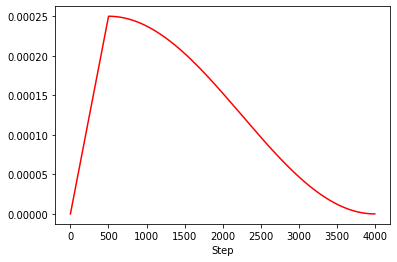

In [31]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

## Î™®Îç∏ ÌïôÏäµ

In [35]:
config_4m = Config({"d_model": 256, 
                 "n_head": 4, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 3, 
                 "n_seq": 256, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config_4m.n_vocab = len(vocab)
config_4m.i_pad = vocab.pad_id()
print('Config : ', config_4m)
# Î™®Îç∏ ÏÉùÏÑ±
model_4 = build_model_pre_train(config=config_4m)
model_4.summary()

Config :  {'d_model': 256, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'd_ff': 1024, 'layernorm_epsilon': 0.001, 'n_layer': 3, 'n_seq': 256, 'n_vocab': 8007, 'i_pad': 0}
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4387328     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
______________________

In [49]:
config = Config({"d_model": 128, 
                 "n_head": 2, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 512, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 2, 
                 "n_seq": 128, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
print('Config : ', config)

# Î™®Îç∏ ÏÉùÏÑ±
model_1 = build_model_pre_train(config)
model_1.summary()


Config :  {'d_model': 128, 'n_head': 2, 'd_head': 64, 'dropout': 0.1, 'd_ff': 512, 'layernorm_epsilon': 0.001, 'n_layer': 2, 'n_seq': 128, 'n_vocab': 8007, 'i_pad': 0}
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1438336     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
_______________________

In [36]:
config = Config({"d_model": 128, 
                 "n_head": 2, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 512, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 2, 
                 "n_seq": 128, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
print('Config : ', config)

# Î™®Îç∏ ÏÉùÏÑ±
model_1 = build_model_pre_train(config)
model_1.summary()

#
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


# compile
# nsp loss : sparse_categorical_crossentropy
# mlm loss : lm_loss (Ïòà: MLMÏùÑ ÏúÑÌïú ÏÇ¨Ïö©Ïûê Ï†ïÏùò Ìï®Ïàò)
#pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), \
#                       optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})
model_1.compile(
                loss={"nsp": tf.keras.losses.sparse_categorical_crossentropy, 
                      "mlm": lm_loss},
                optimizer=optimizer,
                metrics={"nsp": "accuracy", 
                         "mlm": lm_acc}
                )

# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train_1.hdf5",\
                monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", \
                ave_freq="epoch", save_weights_only=True)
# train
history_1 = model_1.fit(train_inputs, train_labels,
                              epochs=epochs, 
                              batch_size=batch_size, 
                              callbacks=save_weights,
                              validation_data=(test_inputs, test_labels)
                       )


Config :  {'d_model': 128, 'n_head': 2, 'd_head': 64, 'dropout': 0.1, 'd_ff': 512, 'layernorm_epsilon': 0.001, 'n_layer': 2, 'n_seq': 128, 'n_vocab': 8007, 'i_pad': 0}
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1438336     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
_______________________

In [55]:
print(history_1.history.keys())

dict_keys(['loss', 'nsp_loss', 'mlm_loss', 'nsp_accuracy', 'mlm_lm_acc', 'val_loss', 'val_nsp_loss', 'val_mlm_loss', 'val_nsp_accuracy', 'val_mlm_lm_acc'])


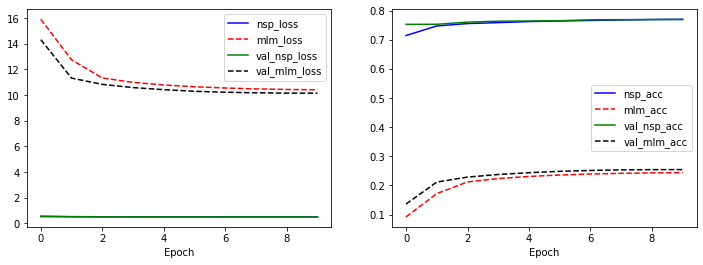

In [38]:
# training result
plt.figure(figsize=(12, 4))

history = history_1

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.plot(history.history['val_nsp_loss'], 'g-', label='val_nsp_loss')
plt.plot(history.history['val_mlm_loss'], 'k--', label='val_mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_accuracy'], 'b-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'r--', label='mlm_acc')
plt.plot(history.history['val_nsp_accuracy'], 'g-', label='val_nsp_acc')
plt.plot(history.history['val_mlm_lm_acc'], 'k--', label='val_mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Í≤∞Í≥ºÎ¨º Ï†ÄÏû•

In [41]:
# Ï†ÄÏû•
save_model_path = model_dir + "/mini_bert_model"
save_weights_path = model_dir + "/mini_bert_weights.h5"

model_1.save(save_model_path, include_optimizer=False)
model_1.save_weights(save_weights_path)

INFO:tensorflow:Assets written to: ./models/mini_bert_model/assets


INFO:tensorflow:Assets written to: ./models/mini_bert_model/assets


In [46]:
# tokenizer_config.json	ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Íµ¨ÏÑ± Ï†ÄÏû•Ïö©
import json

tokenizer_config = {
    "model_file": "ko_8000.model",     # SentencePiece Î™®Îç∏ ÌååÏùº Í≤ΩÎ°ú
    "vocab_file": "ko_8000.vocab",
    "vocab_size": 8000 + 7,                 # ÌïôÏäµ Ïãú ÏÑ§Ï†ïÌïú vocab ÌÅ¨Í∏∞, 7Í∞ú ÌäπÏàò ÌÜ†ÌÅ∞ Ìè¨Ìï®
    "pad_id": 0,
    "pad_piece": "[PAD]",
    "unk_id": 1,
    "unk_piece": "[UNK]",
    "bos_id": 2,
    "bos_piece": "[BOS]",
    "eos_id": 3,
    "eos_piece": "[EOS]",
    "user_defined_symbols": ["[SEP]", "[CLS]", "[MASK]"],
    "model_type": "bpe",
    "add_bos": True,                         # encode Ïãú BOS Î∂ôÏù¥Îäî Í≤ΩÏö∞
    "add_eos": True,                         # encode Ïãú EOS Ï∂îÍ∞Ä Ïó¨Î∂Ä
    "normalization_rule_name": "nmt_nfkc",   # Í∏∞Î≥∏ SentencePiece normalization (ÌïÑÏöî Ïãú Ï°∞Ï†ï)
    "split_by_whitespace": True              # Í≥µÎ∞± Í∏∞Ï§Ä Î∂ÑÌï† Ïó¨Î∂Ä (Í∏∞Î≥∏ True)
}
tokenizer_config_path = model_dir + "/tokenizer_config.json"

# Ï†ÄÏû•
with open(tokenizer_config_path, "w", encoding="utf-8") as f:
    json.dump(tokenizer_config, f, indent=4, ensure_ascii=False)

    
print("tokenizer_config.json:" )
# ÌååÏùº ÏùΩÍ∏∞
with open(tokenizer_config_path, "r") as f:
    tok_config = json.load(f)

# Ï∂úÎ†•
print(json.dumps(tok_config, indent=4, ensure_ascii=False))  # ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ

tokenizer_config.json:
{
    "model_file": "ko_8000.model",
    "vocab_file": "ko_8000.vocab",
    "vocab_size": 8007,
    "pad_id": 0,
    "pad_piece": "[PAD]",
    "unk_id": 1,
    "unk_piece": "[UNK]",
    "bos_id": 2,
    "bos_piece": "[BOS]",
    "eos_id": 3,
    "eos_piece": "[EOS]",
    "user_defined_symbols": [
        "[SEP]",
        "[CLS]",
        "[MASK]"
    ],
    "model_type": "bpe",
    "add_bos": true,
    "add_eos": true,
    "normalization_rule_name": "nmt_nfkc",
    "split_by_whitespace": true
}


In [50]:
# pretrain_config.json
# - Î™®Îç∏ Íµ¨ÏÑ± (hidden size, layers Îì±) Ï†ÄÏû•Ïö©
import json

# ÌååÏùº Í≤ΩÎ°ú ÏßÄÏ†ï
config_path = model_dir + "/pretrain_config.json"

# Ï†ÄÏû•
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print("pretrain_config.json:" )
# ÌååÏùº ÏùΩÍ∏∞
with open(config_path, "r") as f:
    model_config = json.load(f)

# Ï∂úÎ†•
print(json.dumps(model_config, indent=4, ensure_ascii=False))  # ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ

pretrain_config.json:
{
    "d_model": 128,
    "n_head": 2,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 512,
    "layernorm_epsilon": 0.001,
    "n_layer": 2,
    "n_seq": 128,
    "n_vocab": 8007,
    "i_pad": 0
}


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


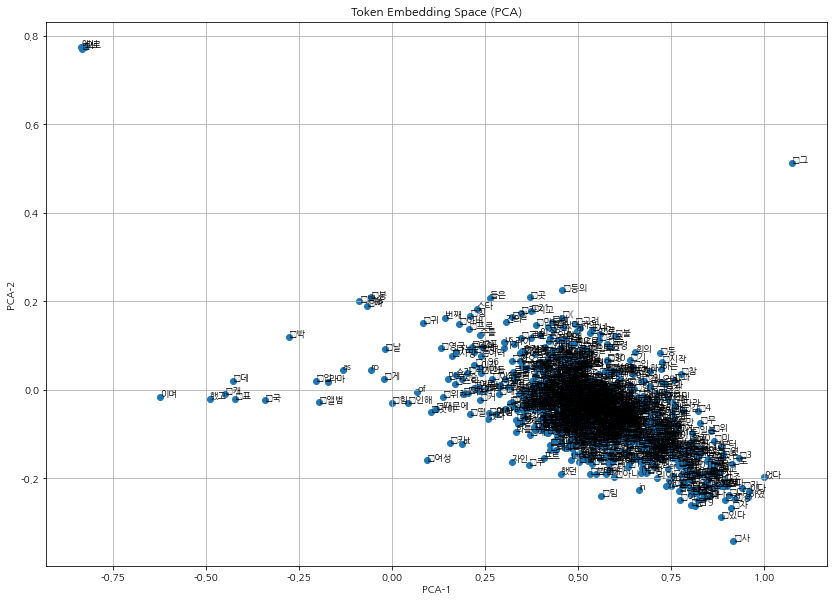

In [72]:
#ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ ÏãúÍ∞ÅÌôî (PCA)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import sentencepiece as spm
import matplotlib.font_manager as fm

# 3. ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ Î°úÎî© (Ïòà: shared embedding layerÏùò Í∞ÄÏ§ëÏπò)
embedding_matrix = model_1.get_layer("bert").embedding.shared_weights.numpy()

# 4. PCA Ï†ÅÏö©
pca = PCA(n_components=2)
reduced = pca.fit_transform(embedding_matrix)


# 5. ÏãúÍ∞ÅÌôî (ÏÉÅÏúÑ NÍ∞ú Îã®Ïñ¥Îßå)
n = 1000
plt.figure(figsize=(14, 10))
plt.scatter(reduced[:n, 0], reduced[:n, 1], marker='o')

for i in range(n):
    plt.text(reduced[i, 0], reduced[i, 1], vocab_list[i], fontsize=9)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

plt.title("Token Embedding Space (PCA)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)

## 7. Inference

In [43]:
import tensorflow as tf
import sentencepiece as spm
import numpy as np

# Í≤ΩÎ°ú ÏÑ§Ï†ï
model_dir = './models'
model_path = f"{model_dir}/mini_bert_model"
model_weights_path = f"{model_dir}/mini_bert_weights.h5"
model_config = f"{model_dir}/pretrain_config.json"
sp_model_path = f"{model_dir}/ko_8000.model"  # SentencePiece Î™®Îç∏ Í≤ΩÎ°ú

# SentencePiece Î°úÎìú
sp = spm.SentencePieceProcessor()
sp.load(sp_model_path)

vocab_list = []
for id in range(7, len(sp)):
        if not sp.is_unknown(id):
            vocab_list.append(sp.id_to_piece(id))

# ÌôïÏù∏
mask_token_id = sp.piece_to_id("[MASK]")
print("mask_token_id:", mask_token_id)
print(f"Ï†ïÏÉÅ ÌÜ†ÌÅ∞ Ïàò: {len(vocab_list)}")
print("ÏòàÏãú:", vocab_list[1:10])




# Î™®Îç∏ Î°úÎìú (Íµ¨Ï°∞ + Í∞ÄÏ§ëÏπò Ìè¨Ìï®)
model = tf.keras.models.load_model(save_model_path, compile=False)
model.summary()



mask_token_id: 6
Ï†ïÏÉÅ ÌÜ†ÌÅ∞ Ïàò: 8000
ÏòàÏãú: ['‚ñÅÏù¥', 'ÏúºÎ°ú', 'ÏóêÏÑú', '‚ñÅÏûà', '‚ñÅ2', '‚ñÅÍ∑∏', '‚ñÅÎåÄ', '‚ñÅÏÇ¨', 'Ïù¥Îã§']


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1438336     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            16768       bert[0][0]                 

** Î¨∏Ïû• Î≥µÏõê **

In [88]:
# Î¨∏Ïû•ÏùÑ ÌÜ†ÌÅ¨ÎÇòÏù¥Ïßï Î∞è Ïù∏Îç±Ïä§ Î≥ÄÌôò Ìï®Ïàò
def tokenize_sentence(sentences, spm, vocab_list, n_seq=128, mask_prob=0.15 ):

    doc = []
    for line in sentences:
        line = line.strip()
        print(line)
        pieces = spm.encode_as_pieces(line) 
        if 0 < len(pieces):
            doc.append(pieces)
        
    print("doc :", doc)
    instances = create_pretrain_instances(spm, doc, n_seq, mask_prob, vocab_list)
    
    print(f"ÏÉùÏÑ±Îêú Ïù∏Ïä§ÌÑ¥Ïä§ Ïàò: {len(instances)}")
    
    #label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
    #label_mlm[ instances[0]["mask_idx"] ] = instances[0]["mask_label"]
    
    """
       instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
        }
            
    return (enc_tokens, segments), (labels_nsp, labels_mlm)
    """
    if not instances:
        raise ValueError("ÏûÖÎ†• Î¨∏Ïû•ÏóêÏÑú pretrain instanceÎ•º ÏÉùÏÑ±Ìï† Ïàò ÏóÜÏäµÎãàÎã§. Î¨∏Ïû• ÏàòÎ•º ÎäòÎ¶¨Í±∞ÎÇò Î¨∏Ïû• Í∏∏Ïù¥Î•º ÌôïÏù∏ÌïòÏÑ∏Ïöî.")
    
    #return (instances[0]["tokens"],instances[0]["segment"]), (instances[0]["is_next"], mask_label)
    return (instances[0]["tokens"],instances[0]["segment"])
             
    

# ÏûÖÎ†• Î¨∏Ïû•
texts = [
    "ÎÇòÎäî ÌïôÍµêÏóê Í∞îÎã§.",
    "ÏπúÍµ¨ÏôÄ ÎÜÄÏïòÎã§.",
    "Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§.",
    "Ï†êÏã¨ÏúºÎ°ú ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."
]

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ïßï Î∞è ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ±
masked_tokens, segments = tokenize_sentence(texts, sp, vocab_list)

# Ìä∏ÌÅ∞Ìôî Í≤∞Í≥º Ï∂úÎ†•
print("ÌÜ†ÌÅ∞ Ï∂úÎ†•:", masked_tokens)
print("Segment Ï∂úÎ†•:", segments)


token_ids = [sp.piece_to_id(token) for token in masked_tokens]
enc_tokens = np.array([token_ids], dtype=np.int32)  # batch Ï≤òÎ¶¨
segments = np.array([segments], dtype=np.int32)


# Ï∂îÎ°†
outputs_nsp, outputs_mlm = model([enc_tokens, segments], training=False)

# MASK ÌÜ†ÌÅ∞ Î≥µÏõê
mask_positions = np.where(enc_tokens[0] == mask_token_id)[0]  # Î∞∞Ïó¥(ÎßàÏä§ÌÅ¨ ÏúÑÏπòÎì§)
print("MASK ÏúÑÏπò", mask_positions)

predicted_tokens = masked_tokens.copy()

for pos in mask_positions:
    predicted_token_id = int(tf.argmax(outputs_mlm[0, pos]).numpy())
    pred_token = sp.id_to_piece(predicted_token_id)
    predicted_tokens[pos] = pred_token
    print(f"Masked token at position {pos} predicted as: {pred_token}")

    
# Î¨∏Ïû•ÏúºÎ°ú Î∂ôÏù¥Í∏∞ 
# [CLS], [SEP] ÌÜ†ÌÅ∞ Ï†úÍ±∞
filtered_tokens = [t for t in predicted_tokens if t not in ("[CLS]", "[SEP]")]
sentence = "".join(filtered_tokens).replace("‚ñÅ", " ").strip()

print("ÏõêÎ¨∏ ÌÜ†ÌÅ∞Îì§:", masked_tokens)
print("ÏòàÏ∏° ÌÜ†ÌÅ∞Îì§:", predicted_tokens)
print("ÏõêÎûò   Î¨∏Ïû•:", " ".join(texts))
print("Î≥µÏõêÎêú Î¨∏Ïû•:", sentence)

ÎÇòÎäî ÌïôÍµêÏóê Í∞îÎã§.
ÏπúÍµ¨ÏôÄ ÎÜÄÏïòÎã§.
Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§.
Ï†êÏã¨ÏúºÎ°ú ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.
doc : [['‚ñÅÎÇò', 'Îäî', '‚ñÅÌïôÍµê', 'Ïóê', '‚ñÅ', 'Í∞îÎã§', '.'], ['‚ñÅÏπúÍµ¨', 'ÏôÄ', '‚ñÅÎÜÄ', 'ÏïòÎã§', '.'], ['‚ñÅÏò§Îäò', 'ÏùÄ', '‚ñÅÎÇ†', 'Ïî®', 'Í∞Ä', '‚ñÅÏ¢ã', 'Îã§', '.'], ['‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.']]
ÏÉùÏÑ±Îêú Ïù∏Ïä§ÌÑ¥Ïä§ Ïàò: 1
ÌÜ†ÌÅ∞ Ï∂úÎ†•: ['[CLS]', '‚ñÅÏò§Îäò', 'ÏùÄ', '‚ñÅÎÇ†', 'Ïî®', 'Í∞Ä', '‚ñÅÏ¢ã', 'Îã§', '.', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]', '‚ñÅÎÇò', 'Îäî', '‚ñÅÌïôÍµê', 'Ïóê', '[MASK]', '[MASK]', '[MASK]', '‚ñÅÏπúÍµ¨', 'ÏôÄ', '‚ñÅÎÜÄ', 'ÏïòÎã§', '.', '[SEP]']
Segment Ï∂úÎ†•: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MASK ÏúÑÏπò [23 24 25]
Masked token at position 23 predicted as: ‚ñÅ
Masked token at position 24 predicted as: ÎÖÄ
Masked token at position 25 predicted as: Ïùò
ÏõêÎ¨∏ ÌÜ†ÌÅ∞Îì§: ['[CLS]', '‚

--> Ï∂îÎ°†ÏùÄ Î¨∏Ïû•ÏùÑ ÏÑûÏñ¥ÏÑú ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú, ÏûòÎ™ªÎêú Ï∂îÎ°†Ïù¥Îã§ 



In [101]:
print(type(outputs_nsp))
print(outputs_nsp)

is_next = tf.argmax(outputs_nsp, axis=-1).numpy()[0]

print("NSP ÏòàÏ∏° :",  is_next)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[0.58647454 0.41352546]], shape=(1, 2), dtype=float32)
NSP ÏòàÏ∏° : 0


In [68]:
print( type(masked_tokens))
print( type(enc_tokens))

<class 'list'>
<class 'numpy.ndarray'>


#### MLM ÏòàÏ∏°

In [111]:
def mlm_inference( masked_text, model, sp, n_seq = 128) : 
    # 1. ÌÜ†ÌÅ∞Ìôî
    tokens = ['[CLS]'] + sp.encode(masked_text, out_type=str) + ['[SEP]']

    # 2. segment ÏÑ§Ï†ï (Î¨∏Ïû• 1Îßå ÏûàÏúºÎØÄÎ°ú Ï†ÑÎ∂Ä 0)
    segments = [0] * len(tokens)

    # 3. ÌÜ†ÌÅ∞ ‚Üí ID
    input_ids = [sp.piece_to_id(tok) for tok in tokens]
    mask_token_id = sp.piece_to_id("[MASK]")

    # 4. Í∏∏Ïù¥ ÎßûÏ∂îÍ∏∞ (padding)
    max_len = n_seq
    input_ids += [0] * (max_len - len(input_ids))
    segments += [0] * (max_len - len(segments))

    # 5. ÌÖêÏÑú Î≥ÄÌôò
    input_ids = tf.constant([input_ids], dtype=tf.int32)
    segments = tf.constant([segments], dtype=tf.int32)

    # 6. Ï∂îÎ°†
    _, outputs_mlm = model([input_ids, segments], training=False)


    # MASK ÌÜ†ÌÅ∞ Î≥µÏõê
    mask_positions = np.where(input_ids[0] == mask_token_id)[0]  # Î∞∞Ïó¥(ÎßàÏä§ÌÅ¨ ÏúÑÏπòÎì§)
    print("MASK ÏúÑÏπò", mask_positions)

    predicted_tokens = tokens.copy()

    for pos in mask_positions:
        predicted_token_id = int(tf.argmax(outputs_mlm[0, pos]).numpy())
        pred_token = sp.id_to_piece(predicted_token_id)
        predicted_tokens[pos] = pred_token
        print(f"Masked token at position {pos} predicted as: {pred_token}")

    
    # Î¨∏Ïû•ÏúºÎ°ú Î∂ôÏù¥Í∏∞ 
    # [CLS], [SEP] ÌÜ†ÌÅ∞ Ï†úÍ±∞
    filtered_tokens = [t for t in predicted_tokens if t not in ("[CLS]", "[SEP]")]
    restored_sentence = "".join(filtered_tokens).replace("‚ñÅ", " ").strip()


    print(" ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•:", masked_text)
    print(" ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞:", predicted_tokens)
    print(" Î≥µÏõêÎêú Î¨∏Ïû•:", restored_sentence)

In [112]:
# ÏûÖÎ†• Î¨∏Ïû•
masked_text = "Ï†êÏã¨ÏúºÎ°ú ÌïôÍµêÏóêÏÑú [MASK] [MASK] Î®πÏóàÎã§."

mlm_inference( masked_text, model, sp)

MASK ÏúÑÏπò [7 9]
Masked token at position 7 predicted as: ‚ñÅÏÇ¨ÎûåÏù¥
Masked token at position 9 predicted as: ‚ñÅÎì±ÏùÑ
 ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú ÌïôÍµêÏóêÏÑú [MASK] [MASK] Î®πÏóàÎã§.
 ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞: ['[CLS]', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÌïôÍµê', 'ÏóêÏÑú', '‚ñÅ', '‚ñÅÏÇ¨ÎûåÏù¥', '‚ñÅ', '‚ñÅÎì±ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]']
 Î≥µÏõêÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú ÌïôÍµêÏóêÏÑú  ÏÇ¨ÎûåÏù¥  Îì±ÏùÑ Î®πÏóàÎã§.


In [113]:
# ÏûÖÎ†• Î¨∏Ïû•
masked_text = "Ï†êÏã¨ÏúºÎ°ú [MASK] ÎßõÏûàÎäî [MASK] Î®πÏóàÎã§."

mlm_inference( masked_text, model, sp)

MASK ÏúÑÏπò [ 5 10]
Masked token at position 5 predicted as: ‚ñÅÎßåÎì†
Masked token at position 10 predicted as: ‚ñÅÎì±ÏùÑ
 ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú [MASK] ÎßõÏûàÎäî [MASK] Î®πÏóàÎã§.
 ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞: ['[CLS]', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅ', '‚ñÅÎßåÎì†', '‚ñÅ', 'Îßõ', 'ÏûàÎäî', '‚ñÅ', '‚ñÅÎì±ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]']
 Î≥µÏõêÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú  ÎßåÎì† ÎßõÏûàÎäî  Îì±ÏùÑ Î®πÏóàÎã§.


In [114]:
# ÏûÖÎ†• Î¨∏Ïû•
masked_text = "Ï†êÏã¨ÏúºÎ°ú [MASK] [MASK] ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."

mlm_inference( masked_text, model, sp)

MASK ÏúÑÏπò [5 7]
Masked token at position 5 predicted as: ‚ñÅÎßåÎì†
Masked token at position 7 predicted as: ‚ñÅÎì±ÏùÄ
 ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú [MASK] [MASK] ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.
 ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞: ['[CLS]', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅ', '‚ñÅÎßåÎì†', '‚ñÅ', '‚ñÅÎì±ÏùÄ', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]']
 Î≥µÏõêÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú  ÎßåÎì†  Îì±ÏùÄ ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.


In [115]:
# ÏûÖÎ†• Î¨∏Ïû•
masked_text = "Ï†êÏã¨ÏúºÎ°ú [MASK] Îñ°Î≥µÏù¥ÏôÄ [MASK] ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."

mlm_inference( masked_text, model, sp)

MASK ÏúÑÏπò [ 5 12]
Masked token at position 5 predicted as: ‚ñÅÎòêÎäî
Masked token at position 12 predicted as: ‚ñÅÎòêÎäî
 ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú [MASK] Îñ°Î≥µÏù¥ÏôÄ [MASK] ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.
 ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞: ['[CLS]', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅ', '‚ñÅÎòêÎäî', '‚ñÅ', 'Îñ°', 'Î≥µ', 'Ïù¥', 'ÏôÄ', '‚ñÅ', '‚ñÅÎòêÎäî', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]']
 Î≥µÏõêÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú  ÎòêÎäî Îñ°Î≥µÏù¥ÏôÄ  ÎòêÎäî ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.


In [117]:
# ÏûÖÎ†• Î¨∏Ïû•
masked_text = "Ï†êÏã¨ÏúºÎ°ú Îß§Ïö¥ [MASK] Í≥º [MASK] ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."

mlm_inference( masked_text, model, sp)

MASK ÏúÑÏπò [ 7 10]
Masked token at position 7 predicted as: ‚ñÅÍ∞ôÏùÄ
Masked token at position 10 predicted as: ‚ñÅÎòêÎäî
 ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú Îß§Ïö¥ [MASK] Í≥º [MASK] ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.
 ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞: ['[CLS]', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÎß§', 'Ïö¥', '‚ñÅ', '‚ñÅÍ∞ôÏùÄ', '‚ñÅÍ≥º', '‚ñÅ', '‚ñÅÎòêÎäî', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]']
 Î≥µÏõêÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú Îß§Ïö¥  Í∞ôÏùÄ Í≥º  ÎòêÎäî ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§.


In [122]:
# ÏûÖÎ†• Î¨∏Ïû•
masked_text = "Ï†êÏã¨ÏúºÎ°ú Îß§Ïö¥ Îñ°Î≥∂Ïù¥Î•º Î®πÍ≥† Î∞∞Í∞Ä ÏïÑÌååÏÑú [MASK] [MASK] Í∞îÎã§"

mlm_inference( masked_text, model, sp)

MASK ÏúÑÏπò [18 20]
Masked token at position 18 predicted as: ‚ñÅ
Masked token at position 20 predicted as: ‚ñÅÎì±ÏúºÎ°ú
 ÎßàÏä§ÌÇπÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú Îß§Ïö¥ Îñ°Î≥∂Ïù¥Î•º Î®πÍ≥† Î∞∞Í∞Ä ÏïÑÌååÏÑú [MASK] [MASK] Í∞îÎã§
 ÏòàÏ∏°Îêú ÌÜ†ÌÅ∞: ['[CLS]', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÎß§', 'Ïö¥', '‚ñÅ', 'Îñ°', 'Î≥∂', 'Ïù¥Î•º', '‚ñÅÎ®π', 'Í≥†', '‚ñÅÎ∞∞', 'Í∞Ä', '‚ñÅÏïÑ', 'Ìåå', 'ÏÑú', '‚ñÅ', '‚ñÅ', '‚ñÅ', '‚ñÅÎì±ÏúºÎ°ú', '‚ñÅ', 'Í∞îÎã§', '[SEP]']
 Î≥µÏõêÎêú Î¨∏Ïû•: Ï†êÏã¨ÏúºÎ°ú Îß§Ïö¥ Îñ°Î≥∂Ïù¥Î•º Î®πÍ≥† Î∞∞Í∞Ä ÏïÑÌååÏÑú    Îì±ÏúºÎ°ú Í∞îÎã§


#### NSP ÏòàÏ∏°

In [124]:
def nsp_inference( sentence_a, sentence_b, model, sp, n_seq = 128) : 
    sentence_a_tokens = sp.encode_as_pieces(sentence_a) 
    sentence_b_tokens = sp.encode_as_pieces(sentence_b)

    # 2. special tokens Ï∂îÍ∞Ä: [CLS], [SEP], [SEP]
    token_org = ["[CLS]"] + sentence_a_tokens + ["[SEP]"] + sentence_b_tokens + ["[SEP]"]
    segments = [0] * (len(sentence_a_tokens)+2) + [1] * (len(sentence_b_tokens)+1)
    print("TOKEN :", token_org)
    print("SEGM :", segments)

    # 3. ÌÜ†ÌÅ∞ÏùÑ IDÎ°ú Î≥ÄÌôò
    input_ids = [sp.piece_to_id(p) for p in tokens]

    # 4. Í∏∏Ïù¥ ÎßûÏ∂îÍ∏∞ (padding)
    max_len = n_seq
    input_ids += [0] * (max_len - len(input_ids))
    segments += [0] * (max_len - len(segments))

    # 5. numpy ‚Üí tensor
    input_ids = tf.constant([input_ids], dtype=tf.int32)
    segments = tf.constant([segments], dtype=tf.int32)

    # 6. Î™®Îç∏ Ï∂îÎ°†
    outputs_nsp, _ = model([input_ids, segments], training=False)

    # 7. Í≤∞Í≥º Ìï¥ÏÑù
    probs = tf.nn.softmax(outputs_nsp, axis=-1).numpy()[0]
    label = np.argmax(probs)

    print(f"NSP ÏòàÏ∏° Í≤∞Í≥º: {'‚úîÔ∏è Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•' if label == 0 else '‚ùå Î¨¥ÏûëÏúÑ Î¨∏Ïû•'}")
    print(f" - Ïó∞ÏÜç ÌôïÎ•†: {probs[0]:.4f}")
    print(f" - Î¨¥ÏûëÏúÑ ÌôïÎ•†: {probs[1]:.4f}")

In [126]:
# ÏûÖÎ†• Î¨∏Ïû•
sentence_a = "ÎÇòÎäî ÌïôÍµêÏóê Í∞îÎã§. ÏπúÍµ¨ÏôÄ ÎÜÄÏïòÎã§."
sentence_b = "Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§. Ï†êÏã¨ÏúºÎ°ú ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."

nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '‚ñÅÎÇò', 'Îäî', '‚ñÅÌïôÍµê', 'Ïóê', '‚ñÅ', 'Í∞îÎã§', '.', '‚ñÅÏπúÍµ¨', 'ÏôÄ', '‚ñÅÎÜÄ', 'ÏïòÎã§', '.', '[SEP]', '‚ñÅÏò§Îäò', 'ÏùÄ', '‚ñÅÎÇ†', 'Ïî®', 'Í∞Ä', '‚ñÅÏ¢ã', 'Îã§', '.', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP ÏòàÏ∏° Í≤∞Í≥º: ‚úîÔ∏è Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•
 - Ïó∞ÏÜç ÌôïÎ•†: 0.5519
 - Î¨¥ÏûëÏúÑ ÌôïÎ•†: 0.4481


In [128]:
# ÏûÖÎ†• Î¨∏Ïû•
sentence_a = "Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§. Ï†êÏã¨ÏúºÎ°ú ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."
sentence_b = "ÎÇòÎäî ÌïôÍµêÏóê Í∞îÎã§. ÏπúÍµ¨ÏôÄ ÎÜÄÏïòÎã§."

nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '‚ñÅÏò§Îäò', 'ÏùÄ', '‚ñÅÎÇ†', 'Ïî®', 'Í∞Ä', '‚ñÅÏ¢ã', 'Îã§', '.', '‚ñÅÏ†ê', 'Ïã¨', 'ÏúºÎ°ú', '‚ñÅÍπÄ', 'Î∞•', 'ÏùÑ', '‚ñÅÎ®π', 'ÏóàÎã§', '.', '[SEP]', '‚ñÅÎÇò', 'Îäî', '‚ñÅÌïôÍµê', 'Ïóê', '‚ñÅ', 'Í∞îÎã§', '.', '‚ñÅÏπúÍµ¨', 'ÏôÄ', '‚ñÅÎÜÄ', 'ÏïòÎã§', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP ÏòàÏ∏° Í≤∞Í≥º: ‚úîÔ∏è Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•
 - Ïó∞ÏÜç ÌôïÎ•†: 0.5519
 - Î¨¥ÏûëÏúÑ ÌôïÎ•†: 0.4481


In [138]:
sentence_a = "Ï¥àÎ°ùÏÉâ Ï≤†Ìïú ÎåÄÎ¨∏ ÌïòÎÇòÍ∞Ä Î∂ÑÏúÑÍ∏∞Ïóê ÌÅ∞ ÏòÅÌñ•ÏùÑ Ï§ÄÎã§"
sentence_b = "Ïò§Îäò Ï†êÏã¨ Î©îÎâ¥Îäî Î∂àÍ≥†Í∏∞ Ïù¥Îã§."
nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '‚ñÅÏ¥à', 'Î°ù', 'ÏÉâ', '‚ñÅÏ≤†', 'Ìïú', '‚ñÅÎåÄ', 'Î¨∏', '‚ñÅÌïòÎÇò', 'Í∞Ä', '‚ñÅÎ∂Ñ', 'ÏúÑ', 'Í∏∞Ïóê', '‚ñÅÌÅ∞', '‚ñÅÏòÅÌñ•ÏùÑ', '‚ñÅÏ§Ä', 'Îã§', '[SEP]', '‚ñÅÏò§Îäò', '‚ñÅÏ†ê', 'Ïã¨', '‚ñÅÎ©î', 'Îâ¥', 'Îäî', '‚ñÅÎ∂à', 'Í≥†', 'Í∏∞', '‚ñÅÏù¥', 'Îã§', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP ÏòàÏ∏° Í≤∞Í≥º: ‚úîÔ∏è Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•
 - Ïó∞ÏÜç ÌôïÎ•†: 0.5519
 - Î¨¥ÏûëÏúÑ ÌôïÎ•†: 0.4481


In [137]:
# ÏûÖÎ†• Î¨∏Ïû•
#sentence_a = "Î©ãÏßÑ Î∂ÑÏàòÎåÄ Íº≠ ÎÜîÏïºÍ≤†Îã§."
#sentence_a = "ÎÇòÎäî Îî∞ÎùºÍ∞àÎ†§Î®º ÏïÑÏßÅ Î©ÄÏóàÎã§."
sentence_a = "Îçî ÎÖ∏Î†•ÌïòÍ≥† Îçî ÏÑ∏Ïã¨Ìï¥ÏïºÍ≤†Îã§"
sentence_b = "Ï¥àÎ°ùÏÉâ Ï≤†Ìïú ÎåÄÎ¨∏ ÌïòÎÇòÍ∞Ä Î∂ÑÏúÑÍ∏∞Ïóê ÌÅ∞ ÏòÅÌñ•ÏùÑ Ï§ÄÎã§"

nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '‚ñÅÎçî', '‚ñÅÎÖ∏Î†•', 'ÌïòÍ≥†', '‚ñÅÎçî', '‚ñÅÏÑ∏', 'Ïã¨', 'Ìï¥Ïïº', 'Í≤†', 'Îã§', '[SEP]', '‚ñÅÏ¥à', 'Î°ù', 'ÏÉâ', '‚ñÅÏ≤†', 'Ìïú', '‚ñÅÎåÄ', 'Î¨∏', '‚ñÅÌïòÎÇò', 'Í∞Ä', '‚ñÅÎ∂Ñ', 'ÏúÑ', 'Í∏∞Ïóê', '‚ñÅÌÅ∞', '‚ñÅÏòÅÌñ•ÏùÑ', '‚ñÅÏ§Ä', 'Îã§', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP ÏòàÏ∏° Í≤∞Í≥º: ‚ùå Î¨¥ÏûëÏúÑ Î¨∏Ïû•
 - Ïó∞ÏÜç ÌôïÎ•†: 0.3988
 - Î¨¥ÏûëÏúÑ ÌôïÎ•†: 0.6012


In [139]:
sentence_a = "Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§."
sentence_b = "ÎÇòÎäî Ïª¥Ìì®ÌÑ∞Î•º Ï¢ãÏïÑÌïúÎã§."
nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '‚ñÅÏò§Îäò', 'ÏùÄ', '‚ñÅÎÇ†', 'Ïî®', 'Í∞Ä', '‚ñÅÏ¢ã', 'Îã§', '.', '[SEP]', '‚ñÅÎÇò', 'Îäî', '‚ñÅÏª¥Ìì®ÌÑ∞', 'Î•º', '‚ñÅÏ¢ãÏïÑ', 'ÌïúÎã§', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
NSP ÏòàÏ∏° Í≤∞Í≥º: ‚ùå Î¨¥ÏûëÏúÑ Î¨∏Ïû•
 - Ïó∞ÏÜç ÌôïÎ•†: 0.3949
 - Î¨¥ÏûëÏúÑ ÌôïÎ•†: 0.6051


In [145]:
sentence_a = "Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§."
sentence_b = "Ïö¥ÎèôÏû•Ïóê Ï∂ïÍµ¨ÌïòÎü¨ Í∞àÍ±∞Îã§."
nsp_inference( sentence_a, sentence_b, model, sp)

TOKEN : ['[CLS]', '‚ñÅÏò§Îäò', 'ÏùÄ', '‚ñÅÎÇ†', 'Ïî®', 'Í∞Ä', '‚ñÅÏ¢ã', 'Îã§', '.', '[SEP]', '‚ñÅÏö¥Îèô', 'Ïû•Ïóê', '‚ñÅÏ∂ïÍµ¨', 'Ìïò', 'Îü¨', '‚ñÅÍ∞à', 'Í±∞', 'Îã§', '.', '[SEP]']
SEGM : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
NSP ÏòàÏ∏° Í≤∞Í≥º: ‚ùå Î¨¥ÏûëÏúÑ Î¨∏Ïû•
 - Ïó∞ÏÜç ÌôïÎ•†: 0.3949
 - Î¨¥ÏûëÏúÑ ÌôïÎ•†: 0.6051


# <ÌöåÍ≥†>

### Î£®Î∏åÎ¶≠

1. ÌïúÍ∏Ä ÏΩîÌçºÏä§Î•º Í∞ÄÍ≥µÌïòÏó¨ BERT pretrainÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ïûò ÏÉùÏÑ±ÌïòÏòÄÎã§.	
- MLM, NSP taskÏùò ÌäπÏßïÏù¥ Ïûò Î∞òÏòÅÎêú pretrainÏö© Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±Í≥ºÏ†ïÏù¥ Ï≤¥Í≥ÑÏ†ÅÏúºÎ°ú ÏßÑÌñâÎêòÏóàÎã§.
2. Íµ¨ÌòÑÌïú BERT Î™®Îç∏Ïùò ÌïôÏäµÏù¥ ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÏßÑÌñâÎê®ÏùÑ ÌôïÏù∏ÌïòÏòÄÎã§.	
- ÌïôÏäµÏßÑÌñâ Í≥ºÏ†ï Ï§ëÏóê MLM, NSP lossÏùò ÏïàÏ†ïÏ†ÅÏù∏ Í∞êÏÜåÍ∞Ä ÌôïÏù∏ÎêòÏóàÎã§.
3. 1MÏßúÎ¶¨ mini BERT Î™®Îç∏Ïùò Ï†úÏûëÍ≥º ÌïôÏäµÏù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏßÑÌñâÎêòÏóàÎã§.	
- ÌïôÏäµÎêú Î™®Îç∏ Î∞è ÌïôÏäµÍ≥ºÏ†ïÏùò ÏãúÍ∞ÅÌôî ÎÇ¥Ïó≠Ïù¥ Ï†úÏ∂úÎêòÏóàÎã§.

üìÑ Mini BERT Pretraining Í≤∞Í≥º Î¶¨Ìè¨Ìä∏ 

1. Î™®Îç∏ Íµ¨ÏÑ± (Model Config)
| Ìï≠Î™©              | Í∞í      |
|-------------------|---------|
| d_model           | 128     |
| n_head            | 2       |
| d_head            | 64      |
| dropout           | 0.1     |
| d_ff              | 512     |
| layernorm_epsilon | 0.001   |
| n_layer           | 2       |
| n_seq             | 128     |
| n_vocab           | 8007    |
| i_pad             | 0       |
| Total Parameters      | 1.4M      |

2. Pretraining ÏÑ§Ï†ï
| Ìï≠Î™©                  | Í∞í                                |
|-----------------------|-----------------------------------|
| Dataset               | ÎÇòÎ¨¥ ÏúÑÏπò ÎßêÎ≠âÏπò  |
| Tokenizer             | SentencePiece                     |
| Pretrain Task         | MLM + NSP                         |
| Epochs                | 10                                |
| Batch Size            | 64                                |
| Learning Rate Scheduler | Warmup (4000 step)              |
| Max Sequence Length   | 128                               |

3. ÌïôÏäµ Í≤∞Í≥º ÏöîÏïΩ

| Î©îÌä∏Î¶≠         | Final Train | Final Val |
|----------------|-------------|-----------|
| MLM Loss       | 10.4110      | 10.1469     |
| MLM Accuracy   | 0.2437      | 0.2543     |
| NSP Loss       | 0.5036      | 0.5015    |
| NSP Accuracy   | 0.7707     | 0.7695    |



### Inference Í≤∞Í≥º Î∞è ÌöåÍ≥†

1. Î¨∏Ïû• ÏàúÏÑú Î≥ÄÌôò : 50% ÎπÑÏú®Î°ú ÎûúÎç§ÌïòÍ≤å ÏÑûÏñ¥ÏÑú, Î¨∏Ïû• ÏàúÏÑúÍ∞Ä Î∞îÎÄåÏóàÎã§ Ï∂îÎ°†ÏóêÏÑú ÏûòÎ™ª ÏÇ¨Ïö©Ìïú ÏòàÏù¥Îã§. 

    texts = [
        "ÎÇòÎäî ÌïôÍµêÏóê Í∞îÎã§.",
        "ÏπúÍµ¨ÏôÄ ÎÜÄÏïòÎã§.",
        "Ïò§ÎäòÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§.",
        "Ï†êÏã¨ÏúºÎ°ú ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§."
    ]     --> Ï†êÏã¨ÏúºÎ°ú ÍπÄÎ∞•ÏùÑ Î®πÏóàÎã§. ÎÇòÎäî ÌïôÍµêÏóê Í∞îÎã§. ÏπúÍµ¨ÏôÄ ÎÜÄÏïòÎã§. Ïù¥ÏùÄ ÎÇ†Ïî®Í∞Ä Ï¢ãÎã§.
    

2. MLM ÏòàÏ∏° 
   -  [MASK] ÏúÑÏπòÎ•º Î≥ÄÌôîÏãúÌÇ§Î©¥ÏÑú ÌôïÏù∏Ìï¥ Î¥§ÏùÑ Îïå, ÎèôÏùºÌïú ÌÜ†ÌÅ∞Îì§Ïù¥ Í≥ÑÏÜçÌï¥ÏÑú ÏòàÏ∏°ÎêòÎäî ÌòÑÏÉÅÏù¥ ÏûàÎã§. 
   - mini Î™®Îç∏Ïù¥Îùº MLM loss/accuracy ÏÑ±Îä•Ïù¥ Ïïà Ï¢ãÏúºÎØÄÎ°ú, MASKÏóê ÎåÄÌïú ÏòàÏ∏°Ïù¥ Ï¢ãÏßÄ ÏïäÎã§. 
   
3. NSP ÏòàÏ∏° 
    - Ïó∞ÏÜçÎ¨∏Ïû• ÌôïÎ•†Í≥º Î¨¥ÏûëÏúÑ Î¨∏Ïû• ÌôïÎ•†Ïùò Ï∞®Ïù¥Í∞Ä ÌÅ¨ÏßÄ ÏïäÎã§.
    - Í∏∞Î≥∏Ï†ÅÏúºÎ°ú 50%Ïù∏Îç∞, 77% Ï†ïÌôïÎèÑÎ°ù ÏòàÏ∏°ÏùÑ ÌïòÍ≥† ÏûàÎäîÎç∞, Ïã§Ï†ú Ï∂îÎ°† Ïã§ÌóòÏóêÏÑúÎäî Ïûò Ïïà ÎßûÎäî ÎìØ ÌïòÎã§. 

4. Pretrained modelÏùÄ ÏßÅÏ†ëÏì∏ Î™®Îç∏Ïù¥ ÏïÑÎãàÎùº, Í∞êÏÑ±Î∂ÑÎ•ò, QAÍ∞ôÏùÄ downstream taskÏóê ÎßûÍ≤å fine-tuningÌï¥ÏÑú ÏÇ¨Ïö©ÌïòÎäî Í≤É